In [2]:
import pandas as pd
import numpy as np

# Datos ficticios
data = pd.read_csv('/Users/santiagonahuelvillarreal/Downloads/qPCR_ficticia.csv')
# Crear DataFrame
df = pd.DataFrame(data)

Explicación del código:
df['delta_Ct']: Crea una nueva columna en el DataFrame df llamada delta_Ct.
df['gene_of_interest_Ct'] - df['housekeeping_Ct']: Calcula la diferencia entre los Ct del gen de interés y del gen housekeeping.

In [3]:

# Calcular ΔCt (delta Ct) y agregarlo como columna
df['delta_Ct'] = df['Ct_gen_de_interés'] - df['Ct_housekeeping']

# Ver las primeras filas del DataFrame con la nueva columna
print(df.head())

  Tratamiento  Réplica biológica  Réplica técnica  Ct_gen_de_interés  \
0           A                  1                1               22.5   
1           A                  1                2               23.0   
2           A                  1                3               22.7   
3           A                  2                1               21.5   
4           A                  2                2               21.8   

   Ct_housekeeping  delta_Ct  
0             19.2       3.3  
1             19.0       4.0  
2             19.3       3.4  
3             18.9       2.6  
4             18.8       3.0  


ahora que tenemos la columna ΔCt, podemos continuar con el siguiente paso, que es el cálculo de ΔΔCt (delta delta Ct) y la expresión relativa de los genes en relación con el grupo de control.

Paso 2: Calcular el ΔΔCt
El cálculo de ΔΔCt se realiza tomando el ΔCt de las muestras tratadas y restando el ΔCt de las muestras de control.

Supongamos que el grupo de control está etiquetado como "Control" en la columna Treatment. Entonces, calculamos el ΔΔCt para cada muestra en comparación con el control.

In [4]:
# Obtener el valor del ΔCt para el control (lo que se utiliza como referencia) --> B es nuestro tratamiento control
control_delta_Ct = df[df['Tratamiento'] == 'B']['delta_Ct'].mean()
# Calcular ΔΔCt para todas las muestras
df['delta_delta_Ct'] = df['delta_Ct'] - control_delta_Ct

# Ver las primeras filas del DataFrame con la nueva columna
print(df.head())

  Tratamiento  Réplica biológica  Réplica técnica  Ct_gen_de_interés  \
0           A                  1                1               22.5   
1           A                  1                2               23.0   
2           A                  1                3               22.7   
3           A                  2                1               21.5   
4           A                  2                2               21.8   

   Ct_housekeeping  delta_Ct  delta_delta_Ct  
0             19.2       3.3        0.277778  
1             19.0       4.0        0.977778  
2             19.3       3.4        0.377778  
3             18.9       2.6       -0.422222  
4             18.8       3.0       -0.022222  


Explicación del código:
df[df['Treatment'] == 'Control']: Filtra las filas donde el tratamiento es "Control".
control_delta_Ct.mean(): Calcula el valor promedio de ΔCt en el grupo de control (puedes elegir tomar la media de todas las réplicas biológicas del control).
df['delta_Ct'] - control_delta_Ct: Calcula la diferencia entre el ΔCt de cada muestra y el valor promedio del grupo de control, generando la columna ΔΔCt.

Paso 3: Calcular la expresión relativa (usando la fórmula 2^-ΔΔCt)
El siguiente paso es calcular la expresión relativa del gen en las muestras tratadas en comparación con el grupo de control. Esto se hace usando la fórmula: Expresión relativa= 2^-ΔΔCt

In [5]:
# Calcular la expresión relativa (2^-ΔΔCt)
df['relative_expression'] = 2 ** (-df['delta_delta_Ct'])

# Ver las primeras filas del DataFrame con la nueva columna
print(df.head(20))

   Tratamiento  Réplica biológica  Réplica técnica  Ct_gen_de_interés  \
0            A                  1                1               22.5   
1            A                  1                2               23.0   
2            A                  1                3               22.7   
3            A                  2                1               21.5   
4            A                  2                2               21.8   
5            A                  2                3               21.7   
6            A                  3                1               20.8   
7            A                  3                2               21.2   
8            A                  3                3               21.0   
9            B                  1                1               23.5   
10           B                  1                2               23.8   
11           B                  1                3               23.6   
12           B                  2                1 

Explicación del código:
2 ** (-df['delta_delta_Ct']): Calcula la expresión relativa del gen de interés usando la fórmula 
La columna relative_expression mostrará el valor de la expresión relativa de cada muestra.

Paso 4: Crear el gráfico de barras con desviación estándar
Primero, necesitamos calcular la desviación estándar para cada tratamiento (usando las réplicas biológicas) y luego graficar los resultados.

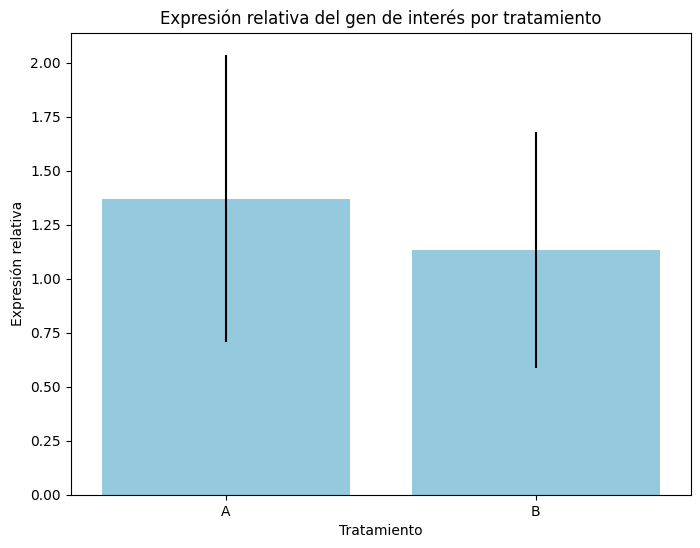

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la desviación estándar para las réplicas biológicas de cada tratamiento
df_grouped = df.groupby('Tratamiento')['relative_expression'].agg(['mean', 'std'])

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x=df_grouped.index, y='mean', data=df_grouped, yerr=df_grouped['std'], capsize=5, color='skyblue')

# Agregar etiquetas y título
plt.xlabel('Tratamiento')
plt.ylabel('Expresión relativa')
plt.title('Expresión relativa del gen de interés por tratamiento')

# Mostrar el gráfico
plt.show()


Para determinar si hay diferencias significativas en la expresión relativa entre los tratamientos, puedes aplicar una prueba estadística que compare las medias de las distintas condiciones. Un test común para este tipo de análisis es el ANOVA (Análisis de Varianza), ya que tienes más de dos grupos (tratamientos). Si el ANOVA muestra diferencias significativas, se puede hacer un análisis post-hoc (por ejemplo, con pruebas de Tukey) para ver cuáles grupos son significativamente diferentes entre sí.

Pasos para agregar el ANOVA y análisis post-hoc:
Realizar un ANOVA para ver si hay diferencias significativas entre los tratamientos.
Si el ANOVA es significativo, realizar una prueba post-hoc (como la prueba de Tukey) para identificar qué pares de tratamientos son significativamente diferentes.

In [7]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Paso 1: Realizar ANOVA
anova_result = ols('relative_expression ~ C(Tratamiento)', data=df).fit()  # 'relative_expression' es la variable dependiente, 'Treatment' es la variable independiente
anova_table = sm.stats.anova_lm(anova_result, typ=2)  # Análisis de varianza de tipo 2
print(anova_table)

# Ver si el p-valor es menor que 0.05 para ver si hay diferencias significativas
if anova_table['PR(>F)'][0] < 0.05:
    print("El ANOVA es significativo, realizamos la prueba de Tukey")
    
    # Paso 2: Realizar prueba de Tukey
    tukey = pairwise_tukeyhsd(df['relative_expression'], df['Tratamiento'])
    print(tukey.summary())
else:
    print("No hay diferencias significativas entre los tratamientos según el ANOVA")


                  sum_sq    df         F    PR(>F)
C(Tratamiento)  0.253727   1.0  0.685174  0.419986
Residual        5.924966  16.0       NaN       NaN
No hay diferencias significativas entre los tratamientos según el ANOVA


/var/folders/0l/pql1hcxx7ps4y6j5nwtgxy480000gn/T/ipykernel_22361/520345265.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:


Explicación:
ANOVA: Compara la media de la expresión relativa entre los diferentes tratamientos. Si el p-valor es menor que 0.05, indica que al menos uno de los tratamientos difiere significativamente de los demás.

Prueba de Tukey: Si el ANOVA es significativo, la prueba de Tukey realiza comparaciones por pares para identificar qué tratamientos son significativamente diferentes entre sí.

¿Qué esperar de los resultados?
Si el ANOVA es significativo, obtendrás un p-valor menor que 0.05, lo que indica que al menos un tratamiento difiere de los demás.

Si el ANOVA es significativo, la prueba de Tukey te dirá qué pares de tratamientos son significativamente diferentes (los valores p de cada comparación).

El resultado del ANOVA muestra que el valor de p (PR(>F)) para el factor Tratamiento es 0.419986, lo que indica que no hay diferencias significativas entre los tratamientos en términos de expresión génica, ya que el valor de p es mayor que el umbral común de 0.05.

Interpretación:
sum_sq (suma de cuadrados) indica la variabilidad explicada por cada fuente de variación.
df es el número de grados de libertad asociados con cada fuente de variación.
F es la estadística F, que compara la variabilidad entre grupos con la variabilidad dentro de los grupos.
PR(>F) es el valor p asociado con la estadística F, y si es mayor que 0.05 (umbral común), se acepta la hipótesis nula, que en este caso sería que no existen diferencias significativas entre los tratamientos.
Conclusión:
Dado que el valor p es mayor que 0.05, se concluye que no hay diferencias estadísticamente significativas en la expresión del gen de interés entre los tratamientos evaluados.








In [8]:
Veamos otros gráficos

SyntaxError: invalid syntax (3118646384.py, line 1)

/var/folders/0l/pql1hcxx7ps4y6j5nwtgxy480000gn/T/ipykernel_22361/548351743.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='Tratamiento', y='delta_Ct', data=df, ci="sd")


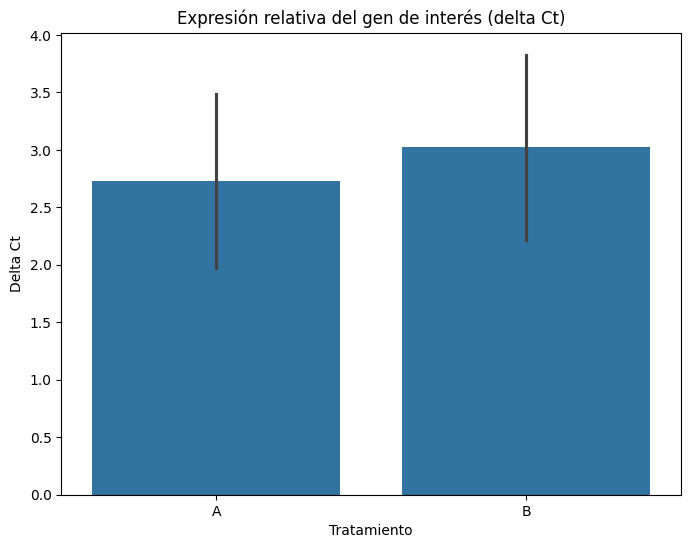

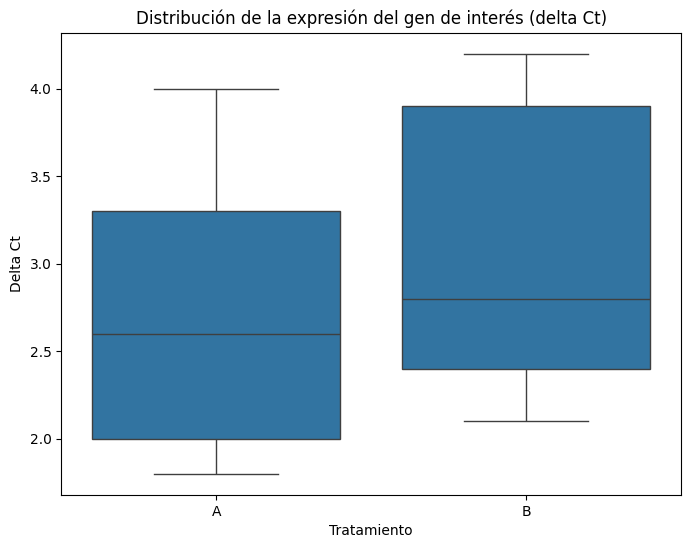

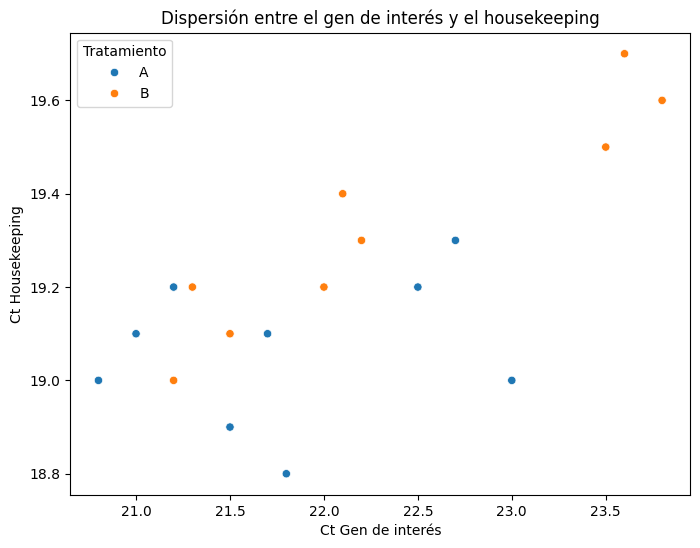

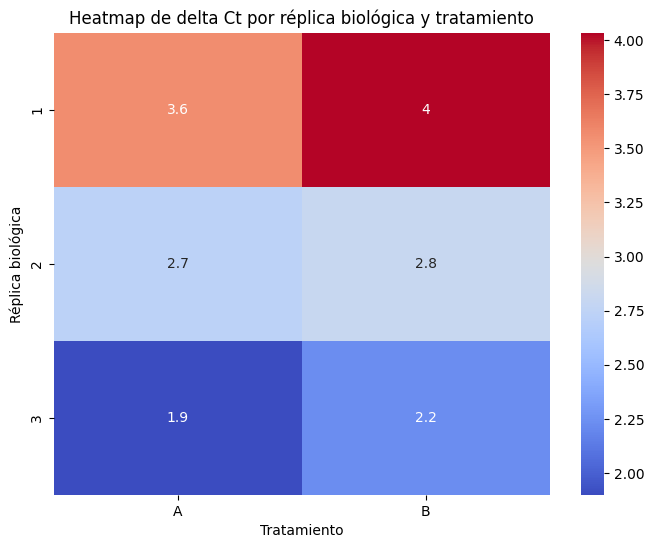

/var/folders/0l/pql1hcxx7ps4y6j5nwtgxy480000gn/T/ipykernel_22361/548351743.py:46: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='Tratamiento', y='delta_Ct', data=df, marker='o', ci="sd")


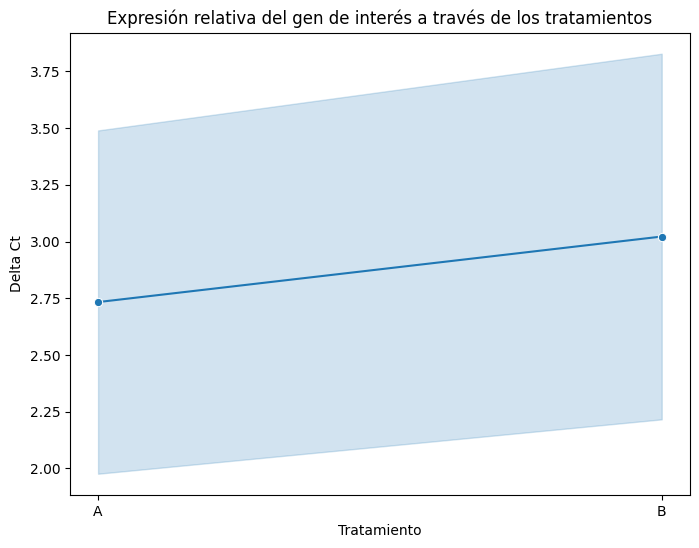

/var/folders/0l/pql1hcxx7ps4y6j5nwtgxy480000gn/T/ipykernel_22361/548351743.py:54: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['delta_Ct'], shade=True, color="r", label="Gen de interés")


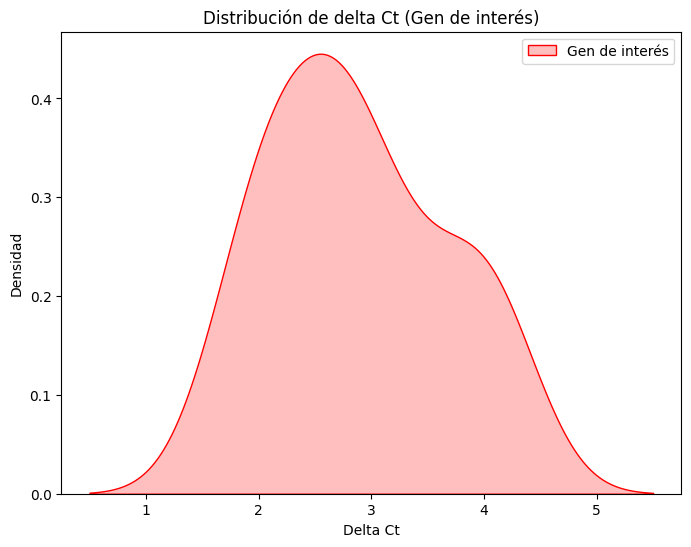

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que tu DataFrame se llama df
# Asegúrate de cargar tus datos de un archivo CSV si es necesario
# df = pd.read_csv("tu_archivo.csv")

# Asegúrate de tener las columnas adecuadas en el DataFrame:
# 'Tratamiento', 'Réplica biológica', 'Réplica técnica', 'Ct_gen_de_interés', 'Ct_housekeeping', 'delta_Ct', 'delta_delta_Ct'

# Gráfico 1: Gráfico de barras con error estándar (delta_Ct)
plt.figure(figsize=(8, 6))
sns.barplot(x='Tratamiento', y='delta_Ct', data=df, ci="sd")
plt.title('Expresión relativa del gen de interés (delta Ct)')
plt.xlabel('Tratamiento')
plt.ylabel('Delta Ct')
plt.show()

# Gráfico 2: Gráfico de cajas (Boxplot) para delta_Ct
plt.figure(figsize=(8, 6))
sns.boxplot(x='Tratamiento', y='delta_Ct', data=df)
plt.title('Distribución de la expresión del gen de interés (delta Ct)')
plt.xlabel('Tratamiento')
plt.ylabel('Delta Ct')
plt.show()

# Gráfico 3: Gráfico de dispersión (Scatter plot) de Ct_gen_de_interés vs Ct_housekeeping
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Ct_gen_de_interés', y='Ct_housekeeping', data=df, hue='Tratamiento')
plt.title('Dispersión entre el gen de interés y el housekeeping')
plt.xlabel('Ct Gen de interés')
plt.ylabel('Ct Housekeeping')
plt.show()

# Gráfico 4: Heatmap de delta_Ct
# Creamos una tabla de resumen para el heatmap
df_summary = df.pivot_table(index='Réplica biológica', columns='Tratamiento', values='delta_Ct', aggfunc='mean')
plt.figure(figsize=(8, 6))
sns.heatmap(df_summary, annot=True, cmap='coolwarm')
plt.title('Heatmap de delta Ct por réplica biológica y tratamiento')
plt.show()

# Gráfico 5: Gráfico de líneas para delta_Ct en los tratamientos
plt.figure(figsize=(8, 6))
sns.lineplot(x='Tratamiento', y='delta_Ct', data=df, marker='o', ci="sd")
plt.title('Expresión relativa del gen de interés a través de los tratamientos')
plt.xlabel('Tratamiento')
plt.ylabel('Delta Ct')
plt.show()

# Gráfico 6: Gráfico de densidad de delta_Ct
plt.figure(figsize=(8, 6))
sns.kdeplot(df['delta_Ct'], shade=True, color="r", label="Gen de interés")
plt.title('Distribución de delta Ct (Gen de interés)')
plt.xlabel('Delta Ct')
plt.ylabel('Densidad')
plt.legend()
plt.show()

# Gráfico 7: Curva de amplificación (simulación)
cycles = np



Descripción de los cambios realizados:
Gráfico de barras con error estándar (delta_Ct): Este gráfico muestra la expresión relativa del gen de interés (usando delta Ct) entre los diferentes tratamientos. El error estándar se calcula automáticamente.
Gráfico de cajas (Boxplot) para delta_Ct: Este gráfico muestra la distribución de la expresión de tu gen de interés (delta Ct) entre los tratamientos. El boxplot incluye los cuartiles y los valores atípicos.
Gráfico de dispersión (Scatter plot): Compara el Ct del gen de interés con el Ct del gen de referencia (housekeeping gene).
Heatmap de delta_Ct: El heatmap muestra la expresión relativa de delta Ct en las diferentes réplicas biológicas por tratamiento.
Gráfico de líneas: Muestra la expresión relativa de delta Ct a lo largo de los tratamientos con barras de error estándar.
Gráfico de densidad (KDE): Este gráfico muestra la distribución de la expresión relativa del gen de interés (delta Ct) en una forma de densidad.
Curva de amplificación: Simula una curva de amplificación típica de qPCR (sin datos experimentales reales).
Curva de dilución (Standard curve): Relaciona la concentración de la plantilla con el valor Ct en una curva de dilución.
